# MITgcm #1: Barotropic Ocean gyre
We will set up the model for a single layer ocean forced by wind stress.

## 1. Problem
We simulate the wind-driven circulation in the mid-latitude setting within the basin whose size is 1200 km x 1200 km.
The depth is 5 km.

### 1.1 Equations
$$
\frac{Du}{Dt} - fv + g\frac{\partial \eta}{\partial x} -A_h \nabla^2_h u = \frac{\tau_x}{\rho_c H} \\
\frac{Dv}{Dt} + fu + g\frac{\partial \eta}{\partial y} -A_h \nabla^2_h v = 0 \\
\frac{\partial \eta}{\partial t} + \nabla_h \cdot (H\mathbf{u}) = 0
$$

## 2. Settings 
This experiment was designed to reproduce the problem described
analytically by *Stommel in 1948* and *Munk in 1950* numerically in *Bryan in 1963*.

### 2.1 Model grid
![domain](https://mitgcm.readthedocs.io/en/latest/_images/new_barotropic_gyre.png)

We consider the wind forcing with only x-component and it varies with latitude following 
$$
 \tau_x(y) = \tau_0 \cos\left(\pi \frac{y}{L_y} \right),
$$
where $\tau_0$ = 0.1 N m$^{-2}$, and $L_y$ = 1200 km.  

This domain has a flat bottom topography, and we consider the beta-plane so that
$$
f(y) = f_0 + \beta y,
$$
where $f_0=10^{-4}$ s$^{-1}$ and $\beta = 10^{-11}$ s$^{-1}$ m$^{-1}$.

(For the generation of the model grid and wind forcing file, you may use the Matlat script, ```gendata.m``` in the ```input``` directory.)  

The default resolution is set to $\Delta x = \Delta y = 20$ km. This means that there should be 60 points in each direction. You need to specify the size of the model.

### 2.2 Compilation
In the ```code``` directory, you can find ```SIZE.h``` file. In here, you can specify the size of the model.  
In addition to specify the size of the model, you can divide your model for the parellel computation.  
If you want to change the resolution, don't forget to edit this file accordingly.

### 2.2 Dissipation
Dissipation form that is commonly used in the MITgcm.
$$
D_v = A_h\nabla^2_hv + A_v\frac{\partial^2 v}{\partial z^2} + A_4\nabla^4_h v,
$$
where $A_h$ and $A_v$ are horizontal and vertical viscosity coefficients and $A_4$ is the horizontal coefficient for biharmonic friction.  

In ```data```, ```viscAh``` and ```viscAz``` represent $A_h$ and $A_v$, respectively.  
```viscA4``` is for $A_4$, and it is zero otherwise specified.

### 2.3 packages
MITgcm can call varied packages (e.g. sea-ice model, biogeochemical model).  
There are two places to specify the packages that you want to use in the model.
1. ```code/packages.conf``` : you need to list the name of the packages so that the appropriate packages are to be compiled.
2. ```input/data.pkg``` : you may skip the packages in the actual run using this file even if those packages were compiled. 

## 3. Running the model

### 3.1 Setting up the ```data``` file
First, let's set 
``` 
endTime=31104000,
monitorFreq=2592000.0,
```
By assigning ```endTime=31104000```, the model will be integrated for one year (unit for ```endTime``` is *second*). 
Alternatively, you can provide the total number of time step. 
In this case, ```nTimeSteps=25920``` gives you the same length of integration.  

By default, each cpu will write the output from the tile it is assigned. If you are using more than one cpu, it means that you will get multiple output files for a single time step.  
If you want to avoid this, you can let only the master MPI write the output after combining the values from all tiles. To do this, you need to add the following line
```
useSingleCpuIO=.TRUE.,
```
under ```PARM01``` in ```data``` file.

### 3.2 Setting up the ```data.pkg``` file
In some cases, you may skip to use a certain package even though you included it during compilation.
In the ```data.pkg``` file, you can specify what packages you want to use among those being compiled.  

In my case, I am not using the netcdf package although it was included in the compilation. So I will edit this file not to include the netcdf file in the run.
```
 useMNC=.FALSE.,
```

### 3.3 Run
If your executable file name is ```mitgcmuv```, you can run the model and pring the output in a text file.
```
./mitgcmuv > stdout
```
The run finishes successfully if you see the following phrase.
```
STOP NORMAL END
```

## 3. Analysis

### 3.1 Using ```rdmds```
Once your run is done, you want to check the output. ```MITgcm``` provides a very useful fucntion called ```rdmds```.
There are both Matlab and Python version of this function, and they can be found under the folder ```utils```.  
For Python, you can set up the ```PYTHONPATH``` in your shell environment file.  

Also, you may find the python script that I wrote to read the grid variables useful.  
You can get it from
https://github.com/hajsong/MITgcmdiag/tree/master/pytools .
Then you have to edit the file ```mitgcmgrid.py``` for this experiment.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from MITgcmutils import rdmds

In [2]:
rdir = '/home/hajsong/Class/tutorial_barotropic_gyre_2022/run_bottom/'
dt = 1200
XC = rdmds(rdir+'XC')
YC = rdmds(rdir+'YC')

In [13]:
eta, its, _ = rdmds(rdir+'Eta', np.nan, returnmeta=True)

In [10]:
u = rdmds(rdir+'U', np.nan)
v = rdmds(rdir+'V', np.nan)
# We want to put u and v to the center point of the grid cell for the interior points.
uc = 0.5*(u[:, 1:-1, 2:] + u[:, 1:-1, 1:-1])
vc = 0.5*(v[:, 2:, 1:-1] + v[:, 1:-1, 1:-1])
spd = np.sqrt(uc**2 + vc**2)

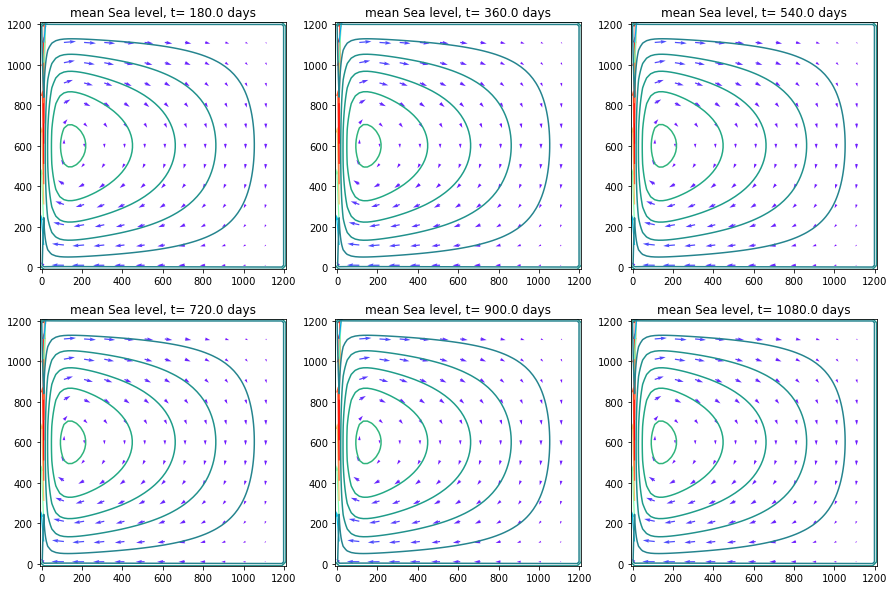

In [11]:
f, ax = plt.subplots(2, 3, figsize=(15,10))
ax = ax.flatten()
vi = 5    # the interval between points in the vector plot
for i, it in enumerate(its[1:]):
    ii = its.index(it)
    ax[i].quiver(XC[1:-1:vi, 1:-1:vi]*1e-3, YC[1:-1:vi,1:-1:vi]*1e-3, 
                 uc[ii,::vi,::vi], vc[ii,::vi,::vi], spd[ii,::vi,::vi], 
                 cmap='rainbow')
    ax[i].contour(XC*1e-3, YC*1e-3, eta[ii,...], np.arange(-.1,.11,.01))
    snaptime = it*dt/86400.
    ax[i].set_title('mean Sea level, t= '+str(snaptime)+' days')

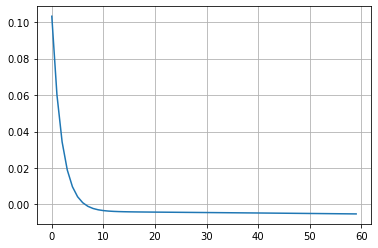

In [15]:
plt.plot(v[-1,31,1:-1])
plt.grid('on')